In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})


<Axes: xlabel='Month'>

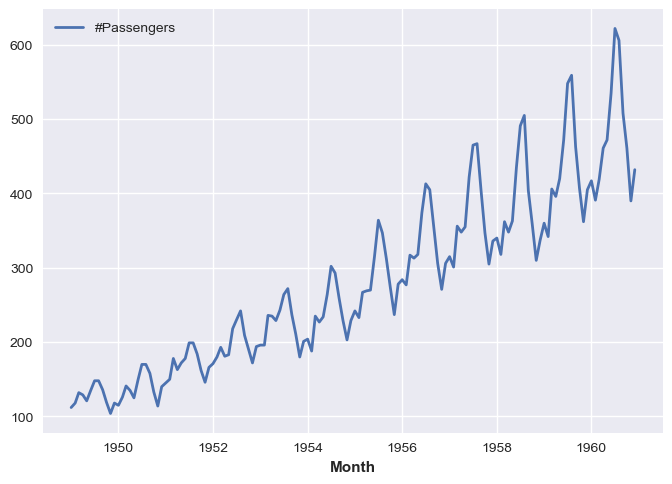

In [2]:
series = AirPassengersDataset().load()
series.plot()

<Axes: xlabel='Month'>

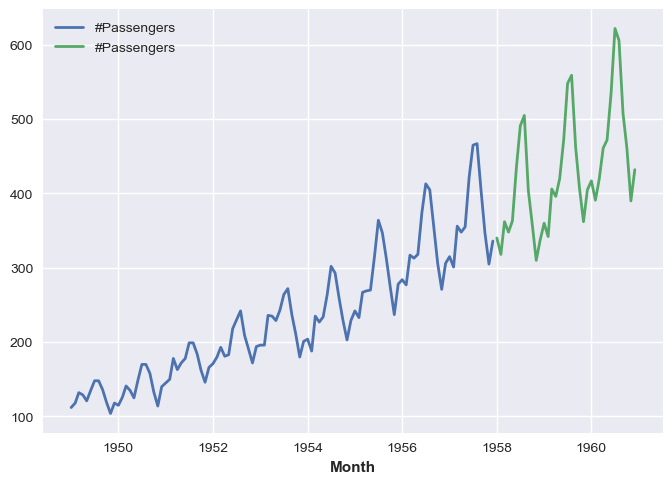

In [3]:
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

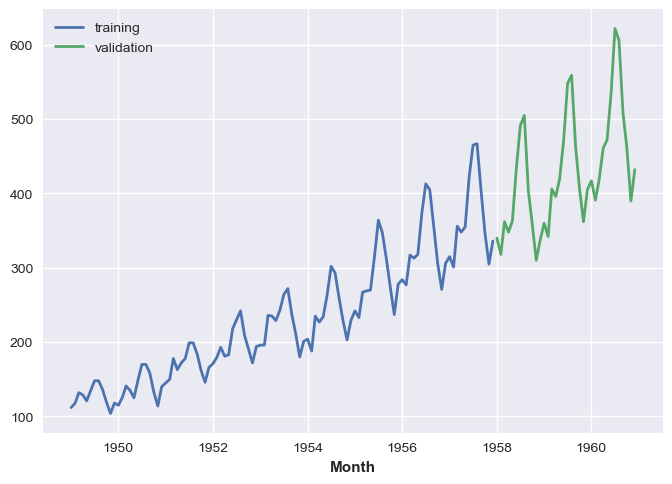

In [4]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

<Axes: xlabel='Month'>

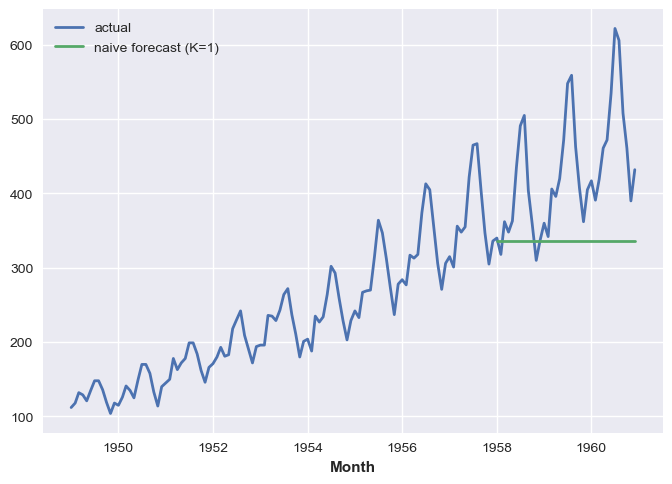

In [5]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


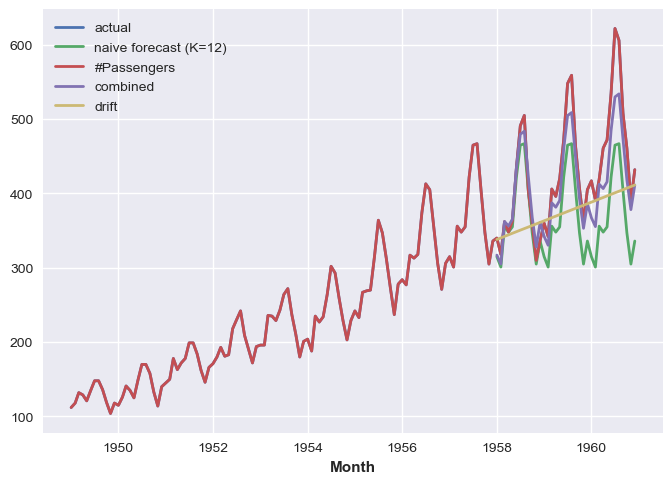

In [6]:
from darts.metrics import mape
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

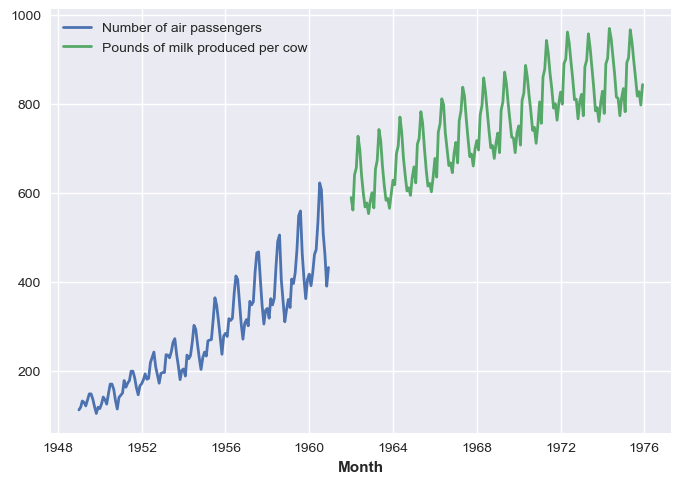

In [9]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

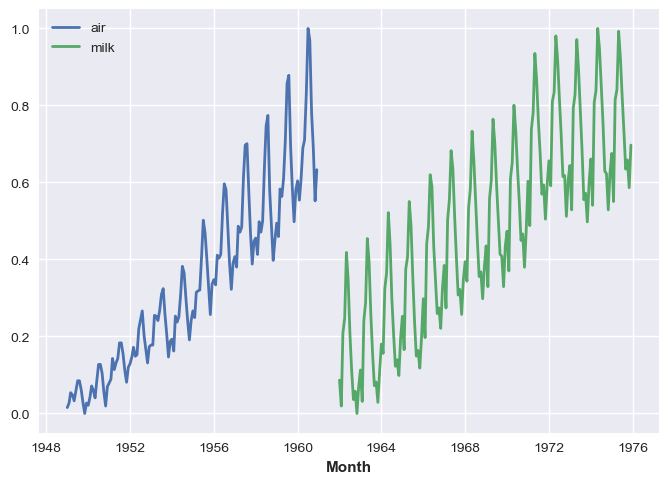

In [10]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

In [12]:
series_air.time_index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [11]:
series_air

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)> Size: 1kB
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None